In [1]:
import sys
sys.path.append('..')

In [2]:
from copy import deepcopy
from pymodulon.gene_util import *
from tqdm.notebook import tqdm
import numpy as np
import os
from Bio import SeqIO

In [3]:
org_dir = '../'
kegg_organism_code = 'sai'
seq_dir = os.path.join(org_dir,'sequence_files')
sacid_seq_dir = os.path.join(org_dir,'Sacid_prokka')

In [4]:
DF_eggnog = pd.read_csv(os.path.join(org_dir,'data','eggNOG.annotations'),sep='\t',skiprows=4,header=None)
eggnog_cols = ['query_name','seed eggNOG ortholog','seed ortholog evalue','seed ortholog score',
               'Predicted taxonomic group','Predicted protein name','Gene Ontology terms',
               'EC number','KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction',
               'KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG Reaction','tax_scope',
               'eggNOG OGs','bestOG_deprecated','COG','eggNOG free text description']

DF_eggnog.columns = eggnog_cols

# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.set_index('query_name')
DF_eggnog.index.name = 'locus_tag'

In [5]:
DF_eggnog['eggNOG OGs']

locus_tag
SACI_RS00005       2XPXH@28889,COG1474@1,arCOG00467@2157
SACI_RS00010                arCOG07173@1,arCOG07173@2157
SACI_RS00015    2XRMH@28889,arCOG01572@1,arCOG01572@2157
SACI_RS00020    2XQP7@28889,arCOG05489@1,arCOG05489@2157
SACI_RS00025                arCOG05883@1,arCOG05883@2157
                                  ...                   
SACI_RS11465       2XRAQ@28889,COG0500@1,arCOG01791@2157
SACI_RS11470       2XQE5@28889,COG2423@1,arCOG01035@2157
SACI_RS11475       2XQXF@28889,COG2096@1,arCOG00489@2157
SACI_RS11480                   COG4934@1,arCOG03665@2157
SACI_RS11485       2XPUT@28889,COG0538@1,arCOG01164@2157
Name: eggNOG OGs, Length: 2173, dtype: object

In [6]:
locus2arCOG = dict.fromkeys(DF_eggnog.index.tolist())

for idx, val in DF_eggnog['eggNOG OGs'].items():
    locus2arCOG[idx] = val.split(',')[-1].split('@')[0]

In [7]:
bad_ones = []

for k,v in locus2arCOG.items():
    if 'arCOG' in v:
        continue
    else:
        bad_ones.append(k)

bad_ones

['SACI_RS11535',
 'SACI_RS11570',
 'SACI_RS04785',
 'SACI_RS06885',
 'SACI_RS07300',
 'SACI_RS10250']

In [8]:
arCOGfunc = pd.read_csv('../data/misc/arCOG.funccat.tsv', sep='\t', header=None, index_col=0)
arCOG2letter = dict.fromkeys(arCOGfunc.index.tolist())

for idx, val in arCOGfunc[1].items():
    arCOG2letter[idx] = val

In [9]:
letter2cat = {
    'J': 'Translation, ribosomal structure and biogenesis',
    'A': 'RNA processing and modification',
    'K': 'Transcription',
    'L': 'Replication, recombination and repair',
    'B': 'Chromatin structure and dynamics',
    'D': 'Cell cycle control, cell division, chromosome partitioning',
    'Y': 'Nuclear structure',
    'V': 'Defense mechanisms',
    'T': 'Signal transduction mechanisms',
    'M': 'Cell wall/membrane/envelope biogenesis',
    'N': 'Cell motility',
    'Z': 'Cytoskeleton',
    'W': 'Extracellular structures',
    'U': 'Intracellular trafficking, secretion, and vesicular transport',
    'O': 'Posttranslational modification, protein turnover, chaperones',
    'X': 'Mobilome: prophages, transposons',
    'C': 'Energy production and conversion',
    'G': 'Carbohydrate transport and metabolism',
    'E': 'Amino acid transport and metabolism',
    'F': 'Nucleotide transport and metabolism',
    'H': 'Coenzyme transport and metabolism',
    'I': 'Lipid transport and metabolism',
    'P': 'Inorganic ion transport and metabolism',
    'Q': 'Secondary metabolites biosynthesis, transport and catabolism',
    'R': 'General Function Prediction Only',
    'S': 'Function Unknown'
}

In [10]:
DF_annot = pd.read_csv('../data/gene_info_curated_with_operons.tsv', sep='\t', index_col=0)
DF_annot

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon
locus_tag,,,,,,,,,,,,,
SACI_RS00005,cdc6-3,Saci_0001,NaN,NaN,101,1261,+,ORC1-type DNA replication protein 3 (AAA famil...,NaN,"Replication, recombination and repair",A0A0U3H3T6,NC_007181.1,Op0
SACI_RS00010,Saci_0002,Saci_0002,Sacid_00002,NaN,1294,1629,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FP71,NC_007181.1,Op0
SACI_RS00015,Saci_0003,Saci_0003,Sacid_00003,NaN,1665,2504,+,hypothetical protein,hypothetical protein,Function unknown,A0A0U2NAH6,NC_007181.1,Op0
SACI_RS00020,Saci_0004,Saci_0004,Sacid_00004,NaN,2553,3056,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3HCE5,NC_007181.1,Op1
SACI_RS00025,Saci_0005,Saci_0005,Sacid_00005,NaN,3049,3768,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FGW8,NC_007181.1,Op1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SACI_RS11465,COQ5_5,Saci_2371,Sacid_02369,NaN,2218618,2219355,-,class I SAM-dependent methyltransferase,"2-methoxy-6-polyprenyl-1,4-benzoquinol methyla...","Secondary metabolites biosynthesis, transport,...",A0A0U2NGD2,NC_007181.1,Op1444
SACI_RS11470,Saci_2372,Saci_2372,Sacid_02370,NaN,2219468,2220394,+,ornithine cyclodeaminase family protein,Delta(1)-pyrroline-2-carboxylate reductase,Amino acid transport and metabolism,A0A0U2Y205,NC_007181.1,Op1445
SACI_RS11475,cobO,Saci_2373,Sacid_02371,NaN,2220381,2220989,-,"cob(I)yrinic acid a,c-diamide adenosyltransferase",Cobalamin adenosyltransferase,Coenzyme transport and metabolism,UPI000055294E,NC_007181.1,Op1446


In [11]:
for idx in DF_annot.index:
    try:
        DF_annot.loc[idx, 'COG'] = letter2cat[ arCOG2letter[ locus2arCOG[idx] ] ]
    except KeyError as E:
        DF_annot.loc[idx, 'COG'] = 'No arCOG annotation'

In [12]:
DF_annot

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon
locus_tag,,,,,,,,,,,,,
SACI_RS00005,cdc6-3,Saci_0001,NaN,NaN,101,1261,+,ORC1-type DNA replication protein 3 (AAA famil...,NaN,"Replication, recombination and repair",A0A0U3H3T6,NC_007181.1,Op0
SACI_RS00010,Saci_0002,Saci_0002,Sacid_00002,NaN,1294,1629,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FP71,NC_007181.1,Op0
SACI_RS00015,Saci_0003,Saci_0003,Sacid_00003,NaN,1665,2504,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U2NAH6,NC_007181.1,Op0
SACI_RS00020,Saci_0004,Saci_0004,Sacid_00004,NaN,2553,3056,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3HCE5,NC_007181.1,Op1
SACI_RS00025,Saci_0005,Saci_0005,Sacid_00005,NaN,3049,3768,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FGW8,NC_007181.1,Op1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
SACI_RS11465,COQ5_5,Saci_2371,Sacid_02369,NaN,2218618,2219355,-,class I SAM-dependent methyltransferase,"2-methoxy-6-polyprenyl-1,4-benzoquinol methyla...","Secondary metabolites biosynthesis, transport ...",A0A0U2NGD2,NC_007181.1,Op1444
SACI_RS11470,Saci_2372,Saci_2372,Sacid_02370,NaN,2219468,2220394,+,ornithine cyclodeaminase family protein,Delta(1)-pyrroline-2-carboxylate reductase,Amino acid transport and metabolism,A0A0U2Y205,NC_007181.1,Op1445
SACI_RS11475,cobO,Saci_2373,Sacid_02371,NaN,2220381,2220989,-,"cob(I)yrinic acid a,c-diamide adenosyltransferase",Cobalamin adenosyltransferase,Coenzyme transport and metabolism,UPI000055294E,NC_007181.1,Op1446


## Final Statistics

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')


Bad key "text.kerning_factor" on line 4 in
/Users/siddharth/opt/miniconda3/envs/pymodulon/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


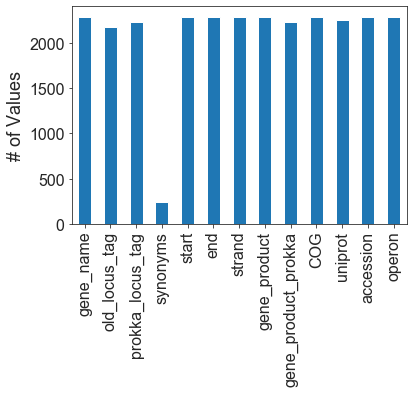

In [14]:
fig,ax = plt.subplots()
DF_annot.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

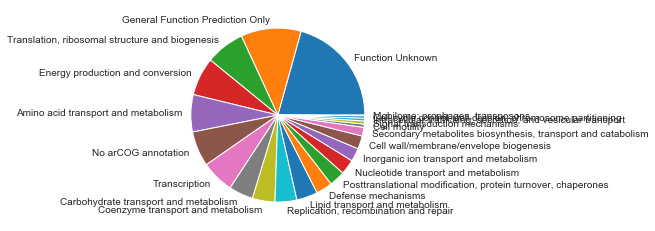

In [15]:
counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

In [16]:
DF_annot.to_csv('../data/gene_info_curated_with_operons_and_arCOGS.tsv', sep='\t')